# Pre processing the data

## Reading the data and setting imports


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import torch

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from textblob import TextBlob

# Baixar recursos necessários
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


df_raw = pd.read_csv('../data/raw/full_data_2020_2025_FORD.csv')
df_raw.head(1)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Year,Make,Model,odiNumber,manufacturer,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,vin,components,summary,products
0,2020,FORD,RANGER,11642687,Ford Motor Company,False,False,0,0,07/14/2023,02/14/2025,1FTER4FH4LL,"ELECTRICAL SYSTEM,FORWARD COLLISION AVOIDANCE",The contact owns a 2020 Ford Ranger. The conta...,"[{'type': 'Vehicle', 'productYear': '2020', 'p..."


## Initial steps to process the data

In [2]:
# Removing unnecessary columns
df_final = df_raw.drop(['Make','odiNumber', 'manufacturer', 'vin', 'products'], axis=1)

In [3]:
# Changing the type of bool to int

df_final['fire'] = df_final['fire'].astype(int)
df_final['crash'] = df_final['crash'].astype(int)

In [4]:
# Converting the 'dateOfIncident' and 'dateComplaintFiled' columns to datetime format
df_final['dateOfIncident'] = pd.to_datetime(df_final['dateOfIncident'])
df_final['dateComplaintFiled'] = pd.to_datetime(df_final['dateComplaintFiled'])

# Creating a new feature that could be valuable for the model: the difference in days between the incident date and the complaint filed date
df_final['daysBetween'] = (df_final['dateComplaintFiled'] - df_final['dateOfIncident']).dt.days


In [5]:
# Splitting the 'components' column into a list of components for each row, handling missing values
df_final["components_list"] = df_final["components"].apply(lambda x: x.split(",") if pd.notna(x) else [])


## Text Processing Section

In [6]:
# Text preprocessing function

def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    
    text = text.lower()
    
    # Tokenization: Split the text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords (common words like 'the', 'and', etc.)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization: Convert words to their base or root form (e.g., 'running' to 'run')
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)  

df_final['processed_summary'] = df_final['summary'].apply(preprocess_text)

In these case i decided to use bert because its a more robust model that generates contextual embeddings.

This is important for analyzing complaints, as it helps capture the full meaning of the text and identify patterns or issues more accurately

I chose BERT over other models because it's lighter while still providing strong contextual embeddings without needing a complete transformer

In [7]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_model_embedding(text):
    """Converts text into a BERT embedding"""
    if pd.isna(text):
        return torch.zeros(512)  
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df_final['summary_embedding'] = df_final['summary'].apply(get_model_embedding)
df_final['model_embedding'] = df_final['Model'].apply(get_model_embedding)


In [8]:
# Calculating the word count and character count for the processed summary
df_final["word_count"] = df_final["processed_summary"].apply(lambda x: len(x.split()))  # Count the number of words
df_final["char_count"] = df_final["processed_summary"].apply(len)  # Count the number of characters

In [10]:
import json
df_final['summary_embedding'] = df_final['summary_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['model_embedding'] = df_final['model_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)

In [11]:
# Calculating the sentiment polarity for each processed summary
df_final['sentiment'] = df_final['processed_summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

# 1.0 → Positive, 0.0 → Neutral, -1.0 → Negative

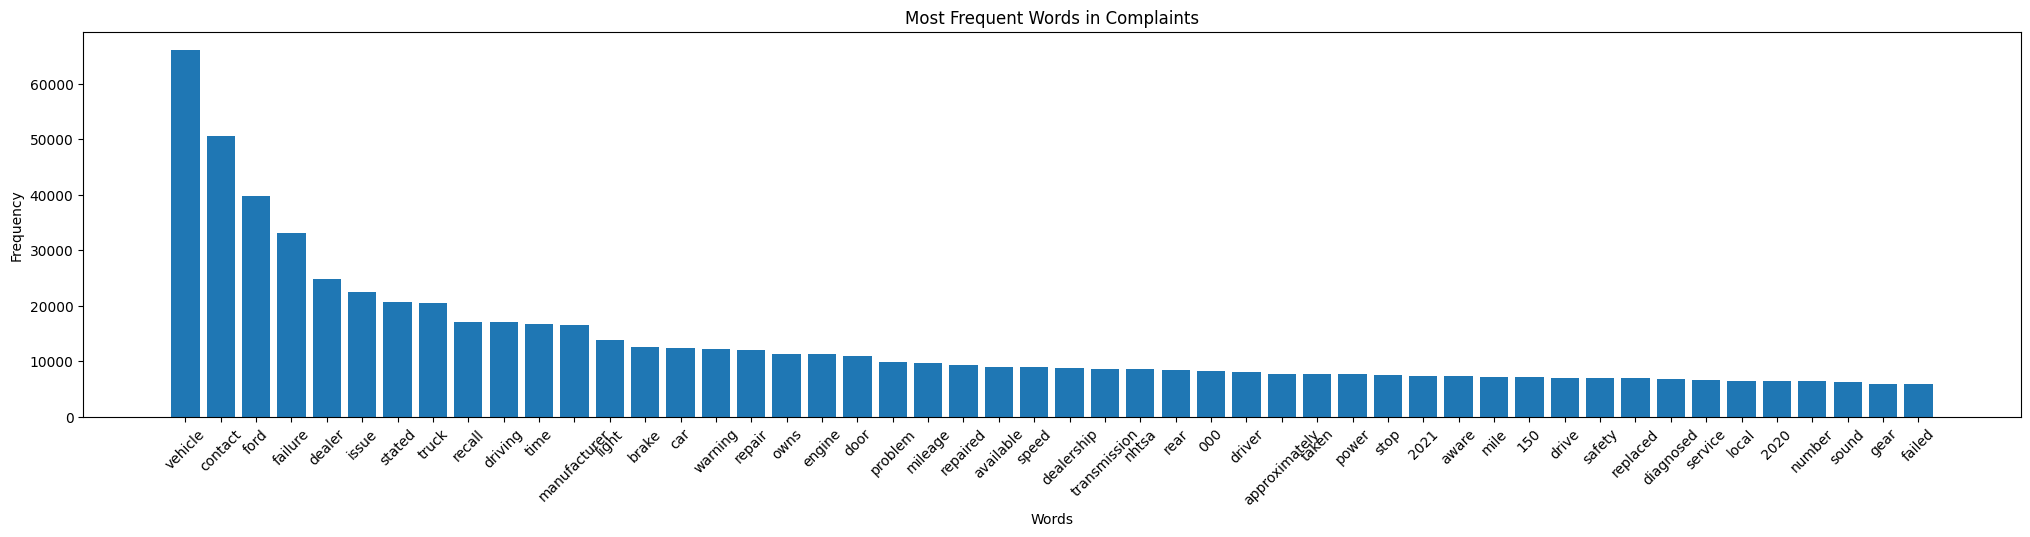

Most Frequent Words in Complaints:
vehicle: 66099
contact: 50556
ford: 39768
failure: 33221
dealer: 24919
issue: 22454
stated: 20783
truck: 20441
recall: 17050
driving: 17044
time: 16661
manufacturer: 16579
light: 13908
brake: 12553
car: 12330
repair: 12137
owns: 11271
engine: 11270
door: 10943
problem: 9928
mileage: 9696
repaired: 9331
available: 8954
speed: 8920
dealership: 8778
transmission: 8703
nhtsa: 8650
rear: 8490
000: 8304
driver: 8053
approximately: 7787
taken: 7710
power: 7663
stop: 7496
2021: 7426
aware: 7303
mile: 7213
150: 7105
drive: 7001
safety: 6994
replaced: 6927
diagnosed: 6736
service: 6567
local: 6535
2020: 6514
number: 6414
sound: 6264
gear: 5967
failed: 5899


In [12]:
texts = df_final['processed_summary'].dropna()  

# Analyzing the most frequent words using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Remove common stopwords and limit to top 50 words
word_counts = vectorizer.fit_transform(texts)  # Transform the text into a matrix of word counts

# Get the most frequent words
words_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1))
sorted_words_freq = sorted(words_freq.items(), key=lambda x: x[1], reverse=True)  # Sort words by frequency

# Visualize the most frequent words with a bar chart
plt.figure(figsize=(25, 5))  
plt.bar(*zip(*sorted_words_freq))  
plt.xticks(rotation=45)  
plt.title('Most Frequent Words in Complaints')  
plt.xlabel('Words')  
plt.ylabel('Frequency')  
plt.show()  

# Display the most frequent words in the console
print("Most Frequent Words in Complaints:")
for word, freq in sorted_words_freq:
    print(f"{word}: {freq}")


The word "recall" appears 6,635 times, suggesting that many complaints are related to safety issues that could result in a recall.

Terms such as "failure" (10,606), "issue" (6,746), "problem" (2,573), and "safety" (2,496) also indicate a strong emphasis on critical technical issues.

Terms like "nhtsa" (3,330) indicate that consumers frequently mention the National Highway Traffic Safety Administration (NHTSA) in their complaints, possibly to report serious failures.

## Components Processing Section

I decided to create a model that can predict the type of problem based solely on the text of vehicle complaints. 

This will help Ford efficiently classify and prioritize issues reported by customers, enabling faster identification of critical components affected, such as safety-related systems or engine performance.

It will help the company identify the major problem with the car without requiring extensive manual review, allowing quicker response times for addressing common defects.

In [13]:
# Analyzing the distribution of data in the 'components
df_final['components_list'].explode().value_counts()

components_list
POWER TRAIN                               10659
ELECTRICAL SYSTEM                          7962
UNKNOWN OR OTHER                           5780
ENGINE                                     5043
STRUCTURE                                  3453
SERVICE BRAKES                             3210
VISIBILITY                                 2204
FORWARD COLLISION AVOIDANCE                2101
VISIBILITY/WIPER                           1918
EXTERIOR LIGHTING                          1452
BACK OVER PREVENTION                       1441
VEHICLE SPEED CONTROL                      1412
STEERING                                   1410
FUEL/PROPULSION SYSTEM                     1318
EQUIPMENT                                  1240
SUSPENSION                                 1101
WHEELS                                     1088
ENGINE AND ENGINE COOLING                   853
LANE DEPARTURE                              673
FUEL SYSTEM                                 618
LATCHES/LOCKS/LINKAGES  

In [14]:
# Mapping the problemns 
category_map = {
    # Engine and Propulsion Systems
    'ENGINE': 'Engine and Propulsion Systems',
    'POWER TRAIN': 'Engine and Propulsion Systems',
    'FUEL SYSTEM': 'Engine and Propulsion Systems',
    'ENGINE AND ENGINE COOLING': 'Engine and Propulsion Systems',
    'HYBRID PROPULSION SYSTEM': 'Engine and Propulsion Systems',
    'FUEL/PROPULSION SYSTEM': 'Engine and Propulsion Systems',
    'HYDRAULIC': 'Engine and Propulsion Systems',
    'GASOLINE': 'Engine and Propulsion Systems',
    'DIESEL': 'Engine and Propulsion Systems',
    
    # Safety and Brakes 
    'AIR BAGS': 'Safety and Brakes',
    'SEAT BELTS': 'Safety and Brakes',
    'SERVICE BRAKES': 'Safety and Brakes',
    'LATCHES/LOCKS/LINKAGES': 'Safety and Brakes',
    'PARKING BRAKE': 'Safety and Brakes',
    'FORWARD COLLISION AVOIDANCE': 'Safety and Brakes',
    'HARNESS': 'Safety and Brakes',
    'BUCKLE': 'Safety and Brakes',
    'CHEST CLIP': 'Safety and Brakes',
    'TETHER': 'Safety and Brakes',
    'LOWER ANCHOR (ON CAR SEAT OR VEHICLE)': 'Safety and Brakes',
    
    # Electrical Systems 
    'ELECTRICAL SYSTEM': 'Electrical Systems',
    'ELECTRONIC STABILITY CONTROL (ESC)': 'Electrical Systems',
    'EXTERIOR LIGHTING': 'Electrical Systems',
    'VISIBILITY': 'Electrical Systems',
    'VISIBILITY/WIPER': 'Electrical Systems',
    'INTERIOR LIGHTING': 'Electrical Systems',
    
    # Vehicle Control and Structure
    'STRUCTURE': 'Vehicle Control and Structure',
    'STEERING': 'Vehicle Control and Structure',
    'WHEELS': 'Vehicle Control and Structure',
    'TIRES': 'Vehicle Control and Structure',
    'SUSPENSION': 'Vehicle Control and Structure',
    'VEHICLE SPEED CONTROL': 'Vehicle Control and Structure',
    'LANE DEPARTURE': 'Vehicle Control and Structure',
    'TRACTION CONTROL SYSTEM': 'Vehicle Control and Structure',
    
    # Miscellaneous and Other Problems
    'UNKNOWN OR OTHER': 'Miscellaneous and Other Problems',
    'BACK OVER PREVENTION': 'Miscellaneous and Other Problems',
    'TRAILER HITCHES': 'Miscellaneous and Other Problems',
    'COMMUNICATION': 'Miscellaneous and Other Problems',
    'OTHER': 'Miscellaneous and Other Problems',
    'EQUIPMENT': 'Miscellaneous and Other Problems',
    'FIRERELATED': 'Miscellaneous and Other Problems',
    
    # Interior and Comfort Systems
    'SEATS': 'Interior and Comfort Systems',
    'AIR': 'Interior and Comfort Systems',
    
}




# Creating category column without duplicates 
df_final["general_category"] = df_final["components_list"].apply(
    lambda x: list(set(category_map.get(i, "Other Problems") for i in x))
)


general_category
Engine and Propulsion Systems       16364
Electrical Systems                  12911
Vehicle Control and Structure        8733
Miscellaneous and Other Problems     8061
Safety and Brakes                    6370
Other Problems                       1068
Interior and Comfort Systems          439
Name: count, dtype: int64


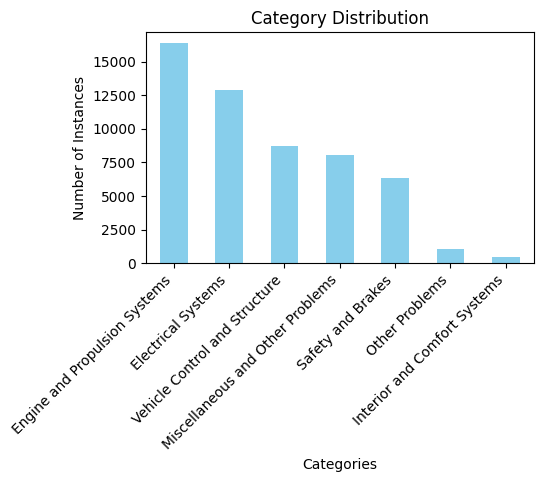

In [15]:
# Here we are plotting the distribution of categories
# Calculate category counts
category_counts = df_final["general_category"].explode().value_counts()

# Display category counts
print(category_counts)

# Plot the distribution
plt.figure(figsize=(5, 3))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.show()


As we can see in the graph above, we have some categories with more data than others.

As we want the model to reflect the operational reality of the most common problems faced we will not apply data balancing.

The model will be evaluated in terms of F1-score, recall and precision and if it significantly favors larger categories we will apply data balancing.

In [16]:
# Checking the mapping 
df_final[['general_category','components_list']].head()

,general_category,components_list
0,"[Safety and Brakes, Electrical Systems]","[ELECTRICAL SYSTEM, FORWARD COLLISION AVOIDANCE]"
1,[Electrical Systems],[VISIBILITY]
2,[Electrical Systems],"[ELECTRICAL SYSTEM, VISIBILITY/WIPER]"
3,[Electrical Systems],[VISIBILITY/WIPER]
4,[Engine and Propulsion Systems],[POWER TRAIN]


### Creating the Multi Label Target 

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

df_final['category_binary'] = ''

mlb = MultiLabelBinarizer()

# Apply the fit_transform method to the 'general_category' column.
# transforming  each category into a binary matrix
y = mlb.fit_transform(list(df_final['general_category']))

df_final['category_binary'] = list(y)

# Example of how the classes look after transformation:
print(mlb.classes_)  
print(y[:5])  


['Electrical Systems' 'Engine and Propulsion Systems'
 'Interior and Comfort Systems' 'Miscellaneous and Other Problems'
 'Other Problems' 'Safety and Brakes' 'Vehicle Control and Structure']
[[1 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]


In [18]:
# Checking the MultiLabelBinarizer Mapping 

df_final[['general_category','category_binary']].head()

,general_category,category_binary
0,"[Safety and Brakes, Electrical Systems]","[1, 0, 0, 0, 0, 1, 0]"
1,[Electrical Systems],"[1, 0, 0, 0, 0, 0, 0]"
2,[Electrical Systems],"[1, 0, 0, 0, 0, 0, 0]"
3,[Electrical Systems],"[1, 0, 0, 0, 0, 0, 0]"
4,[Engine and Propulsion Systems],"[0, 1, 0, 0, 0, 0, 0]"


## Saving My Processed Data

In [19]:
# Checking my final columns

df_final.columns

Index(['Year', 'Model', 'crash', 'fire', 'numberOfInjuries', 'numberOfDeaths',
       'dateOfIncident', 'dateComplaintFiled', 'components', 'summary',
       'daysBetween', 'components_list', 'processed_summary',
       'summary_embedding', 'model_embedding', 'word_count', 'char_count',
       'sentiment', 'general_category', 'category_binary'],
      dtype='object')

In [20]:
df_final['summary_embedding'] = df_final['summary_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['model_embedding'] = df_final['model_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['category_binary'] = df_final['category_binary'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)

In [21]:
# Checking my final df

df_final.head(2)

,Year,Model,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,components,summary,daysBetween,components_list,processed_summary,summary_embedding,model_embedding,word_count,char_count,sentiment,general_category,category_binary
0,2020,RANGER,0,0,0,0,2023-07-14,2025-02-14,"ELECTRICAL SYSTEM,FORWARD COLLISION AVOIDANCE",The contact owns a 2020 Ford Ranger. The conta...,581,"[ELECTRICAL SYSTEM, FORWARD COLLISION AVOIDANCE]",contact owns 2020 ford ranger contact stated d...,"[-0.5945867300033569, -0.2592541575431824, 0.3...","[-0.003329833270981908, -0.24025963246822357, ...",48,384,-0.105556,"[Safety and Brakes, Electrical Systems]","[1, 0, 0, 0, 0, 1, 0]"
1,2020,RANGER,0,0,0,0,2025-01-09,2025-01-09,VISIBILITY,The contact owns a 2020 Ford Ranger. The conta...,0,[VISIBILITY],contact owns 2020 ford ranger contact stated s...,"[-0.46559658646583557, -0.3454362154006958, 0....","[-0.003329833270981908, -0.24025963246822357, ...",41,306,-0.243333,[Electrical Systems],"[1, 0, 0, 0, 0, 0, 0]"


In [22]:
models = df_final['Model'].unique().tolist()


# Define mean and scale values
model_data = {
    "models":models
}
# Save to JSON file
with open('../models/models_params.json', 'w') as f:
    json.dump(model_data, f)


In [23]:
# Saving my final data to use in the model
df_final[['processed_summary', 'summary_embedding', 'model_embedding', 'word_count', 'char_count',
          'sentiment', 'category_binary']].to_csv('../data/processed/df_final_model.csv',index=False)

In [24]:
# Saving my final data to use in analysis
df_final[['Year','Model', 'crash', 'fire', 'numberOfInjuries', 'numberOfDeaths',
       'dateOfIncident', 'dateComplaintFiled', 'summary',
       'daysBetween', 'components_list','sentiment',
       'general_category', 'word_count',
       'char_count']].to_csv('../data/processed/df_final_chart.csv',index=False)